# mmds chapter 3 notes

### 3.3.5 Computing Minhash Signatures

Simulate the effect of random permutations by a random hash function, where the number of discrete hash function ouputs is the same as the number of rows. "Rows" here are basically the indices of a sparse binary vector) So if you have k rows, the hash function maps ints 0, 1, ..., `k-1` to buckets 0 through `k-1`. You can pretend this is a permutation by treating the hash function h(r) as the permuted position of row r.

Use the "permuting" hash functions to build a "signature matrix." You do need potentially hundreds of hash functions. The suggestions I've seen are to use a single hash function and then create the remaining ones by XORing the output with a random k-bit binary string. [See this SO answer.](https://stackoverflow.com/questions/19701052/how-many-hash-functions-are-required-in-a-minhash-algorithm/19711615#19711615)

The algorithm for computing the signatures is roughly this, with some notation differences from mmds:

Starting with:
- A set of $n$ binary vectors with $m$ indices in each vector.
- A set of $h$ hash functions $f_{1..h}$, where each $f_h(i) \in [0, m - 1]$ for all indices $i \in [0, m - 1]$. So each hash function basically returns the "permuted" position of index $i$.

Goals:
- Populate a signature matrix $S$ where $S_{h, j}$ is the signature value for hash function $h$ and vector $j$.


Steps:
1. Initialize all $S_{h, j} = $ infinity
4. For each hash function $f_h$:
  - For each vector $j$:
    - set $S_{h,j}$ = the min of $f_h(i)$ for all $i$ where vector $j$ is "true"
    
Note that section 3.3 in version 3 of the book ([here](http://i.stanford.edu/~ullman/mmds/ch3n.pdf)) has a more efficient min-hashing scheme.

**Example 3.8 in Code**

In [1]:
import numpy as np

# The binary vectors.
V = np.array([
    [1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 1, 1],
    [1, 0, 1, 1, 0]
])

# n is just the number of vectors.
n = len(V)

# The hash functions
H = [
    lambda x: (x + 1) % (n + 1),
    lambda x: (3 * x + 1) % (n + 1)
]

# One row per hash function, one col per vector.
S = np.ones((len(H), len(V))) * np.inf


# This iteration matches the example in the book.
for i in range(len(V[0])):
    for h, f in enumerate(H):
        for j, v in enumerate(V):
            if v[i] == 1:
                S[h][j] = min(S[h][j], f(i))
    print(f"j = {j}")
    print(S)
    print("***")
    
# One row per hash function, one col per vector.
S = np.ones((len(H), len(V))) * np.inf

# This one is a bit more idiomatic, imo. The answer is the same in the end.
for h, f in enumerate(H):
    for j, v in enumerate(V):
        for i, b in enumerate(v):
            if b == 1:
                S[h][j] = min(S[h][j], f(i))
                
S

j = 3
[[ 1. inf inf  1.]
 [ 1. inf inf  1.]]
***
j = 3
[[ 1. inf  2.  1.]
 [ 1. inf  4.  1.]]
***
j = 3
[[1. 3. 2. 1.]
 [1. 2. 4. 1.]]
***
j = 3
[[1. 3. 2. 1.]
 [0. 2. 0. 0.]]
***
j = 3
[[1. 3. 0. 1.]
 [0. 2. 0. 0.]]
***


array([[1., 3., 0., 1.],
       [0., 2., 0., 0.]])

## 3.4 Locality-Sensitive Hashing for Documents (Banding)

Motivation: even though the signatures decrease the cardinality of sets for comparison, you would still have to compare every pair of signature sets to compute apprxomate similarity.

General approach: hash items (from the signature matrix) several times in such a way that similar items are more likely to be hashed to the same bucket than dissimilar items are. Any pair of vectors that hashed to the same bucket for any of the hashings is considered a "candidate pair." 

Approach specific to minhashing: 
- Divide the signature matrix into $b$ bands consisting of $r$ rows each (so $br = h$).
- For each band, hash the vector of r integers into "some large number of buckets." Can use the same hash function on each band, but with separate "bucket arrays."
- Unclear, but I think the hash function could literally just be the identity of the $r$ integers. i.e. `h((1,2,0)) = (1,2,0)`.

**Aside: parameters so far**

I think the minimum parameters needed up to this point are:

1. a random seed to define the hash functions
2. `h` - the number of hash functions. Each one maps to one of $k$ buckets.
3. `b` - the number of bands (you can figure out the rows per band `r = h / b`)


**Example 3.10**

```
band 1   1 0 0 0 2
         3 2 1 1 2
         0 1 3 1 1
band 2   ...
band 3   ...
band 4   ...
```

There are four vectors with signatures (1,3,0), (0,2,1), ...

The two vectors with signature (0,2,1) are candidates in this band.

### 3.4.2 Analysis of the Banding Technique

Assume:
- $b$ bands of $r$ rows each
- a pair of documents has Jaccard similarity $s$
- probability the minhash signature for these documents agreen in any one particular row of the sig. matrix is $s$

We can calculate the probability of becoming candidate pairs:

- P[signatures equal in all rows of a band] = $s^r$
- P[signatures non-equal in at least one row of a band] = 1 - $s^r$
- P[signatures non-equal in at least one row of all bands] = (1 - $s^r$)$^b$
- P[signatures agree in all rows of at least one band] = P[become a candidate pair] = $1 - (1 - s^r)^b$

Expressed as an S-Curve

- The function $1 - (1 - s^r)^b$ takes the shape of an S-curve.
- Threshold: value of similarity $s$ at which the probability of becoming a candidate is 1/2. This is a function of $b$ and $r$.
- The threshold can be approximated as $(1/b)^{1/r}$

**Example 3.11 in Code** 

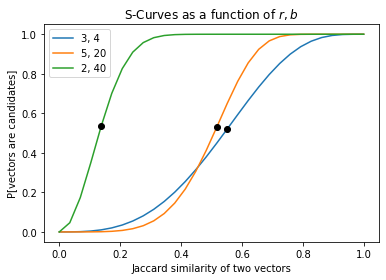

b = 20, r = 5, t ~= 0.55
0.0 : 0.000
0.1 : 0.001
0.2 : 0.019
0.4 : 0.138
0.5 : 0.470
0.6 : 0.865
0.8 : 0.996
0.9 : 1.000
1.0 : 1.000


In [2]:
import matplotlib.pyplot as plt

def scurve(b, r, n = 30):
    s = np.linspace(0, 1, n)
    p = 1. - (1. - s**r)**b
    t = np.argmin(np.abs(p - 0.5))
    return s, p, (s[t], p[t])

def plot(brs):
    for b, r in brs:
        x, y, (tx, ty) = scurve(b, r)
        plt.plot(x, y, label=f"{r}, {b}")
        plt.plot(tx, ty, 'ko')
        plt.xlabel('Jaccard similarity of two vectors')
        plt.ylabel('P[vectors are candidates]')
    plt.title("S-Curves as a function of $r, b$")
    plt.legend()
    plt.show()

def table(b, r):
    tapprox = (1 / b)**(1 / r)
    print(f"b = {b}, r = {r}, t ~= {tapprox:.2f}")
    x, y, _ = scurve(b, r, 9)
    for (x_, y_) in zip(x, y):
        print(f"{x_:.1f} : {y_:.3f}")
    
    
plot([(4, 3), (20, 5), (40, 2)])
table(20, 5)

**Aside: Implementation in Elastiknn**

Pipeline/processor parameters:

- a random seed to define the hash functions
- `k` - the vector dimensions
- `h` - the number of hash functions. Each one maps to one of $k$ buckets.
- `b` - the number of bands (you can figure out the rows per band `r = h / b`)

Pipeline/processor computation:

- given a boolean vector...
- compute the minhash signature
- group the hashed integers into bands

Stored representation of each vector:

- mapping of `band number -> hash value of that band`, e.g.:
```
{
  "1": (1, 3, 99),
  "2": (5, 3, 2),
  "3": (66, 2, 14),
  ...
}
```
- each entry is a keyword

Query:

- given a boolean query vector...
- compute the minhash signature and resulting bands
- construct a boolean query matching the keywords from the query vector.
 


## 3.6 Theory of Locality-Sensitive Functions

Need a family of functions for each distance measure. It must satisfy three conditions:

1. Must be more likely to make close pairs be candidates than distant pairs.
2. Must be statistically independent - i.e. independent probability of hashing resulting in a candidate across many hashes.
3. Must be more efficient than pairwise comparisons

**$(d_1, d_2, p_1, p_2)$ Family of Functions**

$d_1 < d_2$ are two distances according to some distance measure $d$.

A family of functions is $(d_1, d_2, p_1, p_2)$-sensitive if for $0 \leq d_1 \leq d_2$ and every function $f \in F$:

1. if $d(x,y) \leq d_1$, then $P[f(x) = f(y)] \geq p_1$
2. if $d(x,y) \geq d_2$, then $P[f(x) = f(y)] \leq p_2$

In other words: 
- For distances less than $d_1$, the probability of a hash collision has a lower bound at $p_1$. 
- For distances greater than $d_2$, the probability of a hash collision has an upper bound at $p_2$.
- For distances between $d_1$ and $d_2$, the probability is between $p_1$ and $p_2$.


### 3.6.2 Locality-Sensitive Families for Jaccard Distance

The family of minhash functions is a $(d_1, d_2, p_1, p_2)$-sensitive family for any $d_1, d_2$ where $0 \leq d_1 \leq d_2 \leq 1$.

**Example 3.17**

Let $d_1 = 0.3, d_2 = 0.6$. Then the family of minhash functions is a $(0.3, 0.6, 0.7, 0.4)$-sensitive family. Because:

- if $d(x, y) \leq 0.3$, then the probability of a collision is 0.7 (because the probability of a collision is equal to the similarity, and $SIM(x,y) = 1 - d(x,y)$.
- if $d(x, y) \geq 0.6$, the the probability of collision is 0.4.

### 3.6.3 Amplifying a Locality-Sensitive Family

**AND-construction**

Given a $(d_1, d_2, p_1, p_2)$-sensitive family $\bf{F}$, can construct a new family $\bf{F'}$ by the AND-construction:

- Each member of $\bf{F'}$ consists of $r$ members of $F$ for some fixed $r$.
- If $f$ is in $\bf{F'}$ and $f$ is constructed from the set ${f_1, f_2, ..., f_r} \in \bf{F}$, then $f(x) = f(y)$ iff $f_i(x) = f_i(y)$ for all $i = 1,2,...,r$

In other words: $x$ and $y$ are candidates iff they are equal across all rows, or equivalently, equal across all bands..

Since members of $\bf{F}$ are independently chosen to make a member of $\bf{F'}$, we can assert: $\bf{F'}$ is a $(d_1, d_2, (p_1)^r, (p_2)^r)$-sensitive family. (Because the probability of multiple independent events _all_ happening is equal to the product of their probabilities.)

**OR-construction**

Given a $(d_1, d_2, p_1, p_2)$-sensitive family $\bf{F}$, we can construct a new family $\bf{F'}$ by the OR-construction:

- Same as the AND-construction, but this time $f(x) = f(y)$ iff at least one $f_i(x) = f_i(y)$ for $i = 1,2,...,b$ (note using $b$ instead of $r$ here, corresponding to the use of bands instead of rows).

This mirrors the effect of combining several bands, in that $x$ and $y$ become candidates if any of the bands makes them a candidate.

This makes $\bf{F'}$ a $(d_1, d_2, 1 - (1 - p_1)^b, 1 - (1 - p_2)^b)$ -sensitive family $\bf{F}$, because:

- $p$ is the probability that $f(x) = f(y)$ for some member $f \in \bf{F}$.
- $1 - p$ is the probability that $f(x) \neq f(y)$
- $(1 - p)^b$ is the probability that $f_i(x) \neq f_i(y)$ for all $i$ in $1,2,...,b$.
- $1 - (1 - p)^b$ is the probability that $f_i(x) = f_i(y)$ for at least one $i$.

**Effects of amplification**

- AND amplification decreases $p_2$, equivalently decreasing the probability of false positive candidates.
- OR ampliciation increases $p_1$, equivalently decreasing the probability of false negative candidates.

**Cascading AND and OR-constructions**

Cascade AND and OR constructions in any order to make the low probability close to zero and the high probability close to 1, at the cost of applying more hash functions which will take longer.

It seems like this is something that would have to happen when processing and indexing the vectors. I'm also not sure how this interacts with multiprobe LSH.

In [46]:
# https://stackoverflow.com/questions/2702751/operations-on-python-hashes

from hashlib import md5

dim = 1024

hashes = [
    int(md5(bytes([i])).hexdigest(), 16) % dim
#     int(md5(i.to_bytes(2, 'big')).hexdigest(), 16) % dim
    for i in range(dim)
]

print(len(hashes), len(set(hashes)))


h = md5(int(99).to_bytes(2, 'big'))
int(h.hexdigest(), 16) % 1024

ValueError: bytes must be in range(0, 256)